In [22]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt

from cv_svm import SVM_smooth

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
X, y = load_breast_cancer(return_X_y=True)
#X, y = make_classification(n_samples=250, n_features=50)
n = X.shape[0]
p = X.shape[1]
y[np.where(y == 0)] = -1

In [3]:
X_scaled = StandardScaler().fit_transform(X)
print(X_scaled.shape)

(569, 30)


In [4]:
clf = SVC(kernel='linear')
clf.fit(X_scaled, y)
sk_coef_og = clf.coef_.flatten()
sk_coef = clf.coef_/np.linalg.norm(clf.coef_)
print(clf.coef_)
print(clf.intercept_)

[[-0.32157975 -0.0963414  -0.29618472 -0.27044914  0.0145657   0.61925944
  -0.75749079 -0.90968508 -0.07847361  0.34800574 -0.84095245  0.30550603
  -0.23541953 -0.89135374 -0.35509455  0.39115374  0.37739417 -0.46041889
   0.10093298  0.88583541 -0.59013908 -0.97190388 -0.33349947 -0.71227359
  -0.42708268  0.1721726  -1.03818882 -0.09378355 -0.44679874 -0.85526809]]
[0.04438971]


In [5]:
y_pred = clf.predict(X_scaled)
accuracy_score(y, y_pred)

0.9876977152899824

In [6]:
clf = SVM_smooth(sigma=2e-1, lbd=1e-35)
clf.fit(X_scaled, y, thresh=1e-3, n_iter=5000, eta=0.5/n,
        approx_cv=True, cv=True, log_iter=True, log_iacv=True,
        save_cond_nums=True, save_err_approx=True, save_err_cv=True, warm_start=0)
print(f"grad {np.linalg.norm(clf.nabla_fgd_(clf.weights_, X_scaled, y, clf.sigma_, clf.lbd_))}")
coef = clf.weights_/np.linalg.norm(clf.weights_)
print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

y_pred = clf.predict(X_scaled)
accuracy_score(y, y_pred)

iter 0 | grad 2.79731 | objective 1.00990 IACV: 0.00000000 | baseline: 0.00245378
iter 1 | grad 2.79670 | objective 1.00303 IACV: 0.00000000 | baseline: 0.00244895
iter 2 | grad 2.79606 | objective 0.99615 IACV: 0.00000000 | baseline: 0.00244411
iter 3 | grad 2.79539 | objective 0.98929 IACV: 0.00000001 | baseline: 0.00243926
iter 4 | grad 2.79468 | objective 0.98242 IACV: 0.00000001 | baseline: 0.00243441
iter 5 | grad 2.79394 | objective 0.97556 IACV: 0.00000002 | baseline: 0.00242954
iter 6 | grad 2.79317 | objective 0.96870 IACV: 0.00000003 | baseline: 0.00242466
iter 7 | grad 2.79234 | objective 0.96184 IACV: 0.00000004 | baseline: 0.00241976
iter 8 | grad 2.79147 | objective 0.95499 IACV: 0.00000005 | baseline: 0.00241484
iter 9 | grad 2.79055 | objective 0.94815 IACV: 0.00000006 | baseline: 0.00240989
iter 10 | grad 2.78956 | objective 0.94131 IACV: 0.00000008 | baseline: 0.00240491
iter 11 | grad 2.78851 | objective 0.93447 IACV: 0.00000010 | baseline: 0.00239989
iter 12 | grad

iter 101 | grad 1.77957 | objective 0.48334 IACV: 0.00006887 | baseline: 0.00139466
iter 102 | grad 1.76650 | objective 0.48057 IACV: 0.00007059 | baseline: 0.00138497
iter 103 | grad 1.75348 | objective 0.47784 IACV: 0.00007232 | baseline: 0.00137541
iter 104 | grad 1.74053 | objective 0.47514 IACV: 0.00007408 | baseline: 0.00136596
iter 105 | grad 1.72765 | objective 0.47249 IACV: 0.00007585 | baseline: 0.00135662
iter 106 | grad 1.71483 | objective 0.46988 IACV: 0.00007764 | baseline: 0.00134741
iter 107 | grad 1.70209 | objective 0.46730 IACV: 0.00007945 | baseline: 0.00133832
iter 108 | grad 1.68943 | objective 0.46477 IACV: 0.00008128 | baseline: 0.00132935
iter 109 | grad 1.67684 | objective 0.46227 IACV: 0.00008312 | baseline: 0.00132051
iter 110 | grad 1.66433 | objective 0.45981 IACV: 0.00008498 | baseline: 0.00131179
iter 111 | grad 1.65192 | objective 0.45738 IACV: 0.00008686 | baseline: 0.00130321
iter 112 | grad 1.63959 | objective 0.45499 IACV: 0.00008876 | baseline: 0.0

iter 201 | grad 0.97088 | objective 0.33038 IACV: 0.00031010 | baseline: 0.00100195
iter 202 | grad 0.96649 | objective 0.32956 IACV: 0.00031296 | baseline: 0.00100173
iter 203 | grad 0.96214 | objective 0.32874 IACV: 0.00031583 | baseline: 0.00100155
iter 204 | grad 0.95783 | objective 0.32793 IACV: 0.00031870 | baseline: 0.00100140
iter 205 | grad 0.95357 | objective 0.32712 IACV: 0.00032158 | baseline: 0.00100129
iter 206 | grad 0.94934 | objective 0.32632 IACV: 0.00032446 | baseline: 0.00100121
iter 207 | grad 0.94515 | objective 0.32553 IACV: 0.00032735 | baseline: 0.00100116
iter 208 | grad 0.94101 | objective 0.32475 IACV: 0.00033025 | baseline: 0.00100114
iter 209 | grad 0.93690 | objective 0.32397 IACV: 0.00033315 | baseline: 0.00100116
iter 210 | grad 0.93283 | objective 0.32320 IACV: 0.00033605 | baseline: 0.00100120
iter 211 | grad 0.92880 | objective 0.32244 IACV: 0.00033896 | baseline: 0.00100127
iter 212 | grad 0.92481 | objective 0.32169 IACV: 0.00034188 | baseline: 0.0

iter 301 | grad 0.67866 | objective 0.27278 IACV: 0.00061767 | baseline: 0.00107648
iter 302 | grad 0.67673 | objective 0.27238 IACV: 0.00062089 | baseline: 0.00107769
iter 303 | grad 0.67482 | objective 0.27198 IACV: 0.00062412 | baseline: 0.00107891
iter 304 | grad 0.67292 | objective 0.27158 IACV: 0.00062735 | baseline: 0.00108012
iter 305 | grad 0.67103 | objective 0.27118 IACV: 0.00063058 | baseline: 0.00108134
iter 306 | grad 0.66915 | objective 0.27079 IACV: 0.00063381 | baseline: 0.00108257
iter 307 | grad 0.66729 | objective 0.27039 IACV: 0.00063705 | baseline: 0.00108379
iter 308 | grad 0.66543 | objective 0.27000 IACV: 0.00064029 | baseline: 0.00108502
iter 309 | grad 0.66359 | objective 0.26961 IACV: 0.00064352 | baseline: 0.00108625
iter 310 | grad 0.66176 | objective 0.26923 IACV: 0.00064676 | baseline: 0.00108748
iter 311 | grad 0.65994 | objective 0.26884 IACV: 0.00065000 | baseline: 0.00108872
iter 312 | grad 0.65814 | objective 0.26846 IACV: 0.00065325 | baseline: 0.0

iter 401 | grad 0.53258 | objective 0.24108 IACV: 0.00094660 | baseline: 0.00120184
iter 402 | grad 0.53149 | objective 0.24084 IACV: 0.00094994 | baseline: 0.00120308
iter 403 | grad 0.53040 | objective 0.24059 IACV: 0.00095328 | baseline: 0.00120431
iter 404 | grad 0.52931 | objective 0.24034 IACV: 0.00095662 | baseline: 0.00120555
iter 405 | grad 0.52823 | objective 0.24009 IACV: 0.00095997 | baseline: 0.00120679
iter 406 | grad 0.52716 | objective 0.23985 IACV: 0.00096331 | baseline: 0.00120802
iter 407 | grad 0.52609 | objective 0.23961 IACV: 0.00096666 | baseline: 0.00120926
iter 408 | grad 0.52503 | objective 0.23936 IACV: 0.00097001 | baseline: 0.00121049
iter 409 | grad 0.52397 | objective 0.23912 IACV: 0.00097335 | baseline: 0.00121172
iter 410 | grad 0.52292 | objective 0.23888 IACV: 0.00097670 | baseline: 0.00121295
iter 411 | grad 0.52187 | objective 0.23864 IACV: 0.00098005 | baseline: 0.00121418
iter 412 | grad 0.52083 | objective 0.23840 IACV: 0.00098340 | baseline: 0.0

iter 501 | grad 0.44511 | objective 0.22029 IACV: 0.00128450 | baseline: 0.00132077
iter 502 | grad 0.44441 | objective 0.22012 IACV: 0.00128791 | baseline: 0.00132191
iter 503 | grad 0.44372 | objective 0.21995 IACV: 0.00129132 | baseline: 0.00132304
iter 504 | grad 0.44303 | objective 0.21977 IACV: 0.00129473 | baseline: 0.00132417
iter 505 | grad 0.44234 | objective 0.21960 IACV: 0.00129813 | baseline: 0.00132530
iter 506 | grad 0.44166 | objective 0.21943 IACV: 0.00130154 | baseline: 0.00132643
iter 507 | grad 0.44098 | objective 0.21926 IACV: 0.00130495 | baseline: 0.00132756
iter 508 | grad 0.44030 | objective 0.21909 IACV: 0.00130836 | baseline: 0.00132869
iter 509 | grad 0.43962 | objective 0.21892 IACV: 0.00131177 | baseline: 0.00132981
iter 510 | grad 0.43895 | objective 0.21875 IACV: 0.00131518 | baseline: 0.00133094
iter 511 | grad 0.43827 | objective 0.21858 IACV: 0.00131859 | baseline: 0.00133206
iter 512 | grad 0.43761 | objective 0.21841 IACV: 0.00132201 | baseline: 0.0

iter 601 | grad 0.38648 | objective 0.20519 IACV: 0.00162569 | baseline: 0.00142748
iter 602 | grad 0.38598 | objective 0.20505 IACV: 0.00162909 | baseline: 0.00142847
iter 603 | grad 0.38548 | objective 0.20492 IACV: 0.00163249 | baseline: 0.00142946
iter 604 | grad 0.38498 | objective 0.20479 IACV: 0.00163589 | baseline: 0.00143045
iter 605 | grad 0.38449 | objective 0.20466 IACV: 0.00163929 | baseline: 0.00143144
iter 606 | grad 0.38400 | objective 0.20453 IACV: 0.00164270 | baseline: 0.00143242
iter 607 | grad 0.38350 | objective 0.20440 IACV: 0.00164610 | baseline: 0.00143341
iter 608 | grad 0.38301 | objective 0.20427 IACV: 0.00164950 | baseline: 0.00143439
iter 609 | grad 0.38252 | objective 0.20415 IACV: 0.00165290 | baseline: 0.00143537
iter 610 | grad 0.38204 | objective 0.20402 IACV: 0.00165630 | baseline: 0.00143634
iter 611 | grad 0.38155 | objective 0.20389 IACV: 0.00165969 | baseline: 0.00143732
iter 612 | grad 0.38106 | objective 0.20376 IACV: 0.00166309 | baseline: 0.0

iter 701 | grad 0.34253 | objective 0.19355 IACV: 0.00196401 | baseline: 0.00151959
iter 702 | grad 0.34215 | objective 0.19345 IACV: 0.00196738 | baseline: 0.00152045
iter 703 | grad 0.34177 | objective 0.19334 IACV: 0.00197075 | baseline: 0.00152132
iter 704 | grad 0.34139 | objective 0.19324 IACV: 0.00197412 | baseline: 0.00152218
iter 705 | grad 0.34101 | objective 0.19314 IACV: 0.00197749 | baseline: 0.00152305
iter 706 | grad 0.34063 | objective 0.19304 IACV: 0.00198086 | baseline: 0.00152391
iter 707 | grad 0.34025 | objective 0.19294 IACV: 0.00198423 | baseline: 0.00152477
iter 708 | grad 0.33987 | objective 0.19283 IACV: 0.00198759 | baseline: 0.00152563
iter 709 | grad 0.33950 | objective 0.19273 IACV: 0.00199096 | baseline: 0.00152649
iter 710 | grad 0.33912 | objective 0.19263 IACV: 0.00199433 | baseline: 0.00152735
iter 711 | grad 0.33875 | objective 0.19253 IACV: 0.00199770 | baseline: 0.00152821
iter 712 | grad 0.33838 | objective 0.19243 IACV: 0.00200107 | baseline: 0.0

iter 801 | grad 0.30890 | objective 0.18426 IACV: 0.00230047 | baseline: 0.00160301
iter 802 | grad 0.30861 | objective 0.18417 IACV: 0.00230383 | baseline: 0.00160381
iter 803 | grad 0.30832 | objective 0.18409 IACV: 0.00230718 | baseline: 0.00160461
iter 804 | grad 0.30802 | objective 0.18401 IACV: 0.00231054 | baseline: 0.00160541
iter 805 | grad 0.30773 | objective 0.18392 IACV: 0.00231389 | baseline: 0.00160621
iter 806 | grad 0.30744 | objective 0.18384 IACV: 0.00231725 | baseline: 0.00160701
iter 807 | grad 0.30714 | objective 0.18376 IACV: 0.00232060 | baseline: 0.00160781
iter 808 | grad 0.30685 | objective 0.18367 IACV: 0.00232395 | baseline: 0.00160861
iter 809 | grad 0.30656 | objective 0.18359 IACV: 0.00232731 | baseline: 0.00160940
iter 810 | grad 0.30627 | objective 0.18351 IACV: 0.00233066 | baseline: 0.00161020
iter 811 | grad 0.30598 | objective 0.18343 IACV: 0.00233401 | baseline: 0.00161099
iter 812 | grad 0.30570 | objective 0.18334 IACV: 0.00233737 | baseline: 0.0

iter 901 | grad 0.28227 | objective 0.17659 IACV: 0.00263411 | baseline: 0.00167956
iter 902 | grad 0.28203 | objective 0.17652 IACV: 0.00263743 | baseline: 0.00168029
iter 903 | grad 0.28179 | objective 0.17645 IACV: 0.00264075 | baseline: 0.00168102
iter 904 | grad 0.28155 | objective 0.17638 IACV: 0.00264406 | baseline: 0.00168175
iter 905 | grad 0.28131 | objective 0.17631 IACV: 0.00264738 | baseline: 0.00168247
iter 906 | grad 0.28107 | objective 0.17624 IACV: 0.00265069 | baseline: 0.00168320
iter 907 | grad 0.28083 | objective 0.17618 IACV: 0.00265401 | baseline: 0.00168393
iter 908 | grad 0.28060 | objective 0.17611 IACV: 0.00265732 | baseline: 0.00168465
iter 909 | grad 0.28036 | objective 0.17604 IACV: 0.00266063 | baseline: 0.00168538
iter 910 | grad 0.28012 | objective 0.17597 IACV: 0.00266395 | baseline: 0.00168610
iter 911 | grad 0.27988 | objective 0.17590 IACV: 0.00266726 | baseline: 0.00168682
iter 912 | grad 0.27965 | objective 0.17583 IACV: 0.00267057 | baseline: 0.0

iter 1001 | grad 0.26028 | objective 0.17014 IACV: 0.00296460 | baseline: 0.00174983
iter 1002 | grad 0.26008 | objective 0.17008 IACV: 0.00296789 | baseline: 0.00175051
iter 1003 | grad 0.25988 | objective 0.17002 IACV: 0.00297119 | baseline: 0.00175120
iter 1004 | grad 0.25968 | objective 0.16996 IACV: 0.00297449 | baseline: 0.00175188
iter 1005 | grad 0.25948 | objective 0.16990 IACV: 0.00297779 | baseline: 0.00175256
iter 1006 | grad 0.25928 | objective 0.16984 IACV: 0.00298109 | baseline: 0.00175324
iter 1007 | grad 0.25908 | objective 0.16978 IACV: 0.00298439 | baseline: 0.00175392
iter 1008 | grad 0.25889 | objective 0.16972 IACV: 0.00298769 | baseline: 0.00175460
iter 1009 | grad 0.25869 | objective 0.16966 IACV: 0.00299100 | baseline: 0.00175527
iter 1010 | grad 0.25849 | objective 0.16960 IACV: 0.00299429 | baseline: 0.00175595
iter 1011 | grad 0.25829 | objective 0.16955 IACV: 0.00299759 | baseline: 0.00175663
iter 1012 | grad 0.25810 | objective 0.16949 IACV: 0.00300090 | b

iter 1098 | grad 0.24250 | objective 0.16476 IACV: 0.00328518 | baseline: 0.00181467
iter 1099 | grad 0.24233 | objective 0.16471 IACV: 0.00328849 | baseline: 0.00181533
iter 1100 | grad 0.24216 | objective 0.16465 IACV: 0.00329180 | baseline: 0.00181598
iter 1101 | grad 0.24200 | objective 0.16460 IACV: 0.00329512 | baseline: 0.00181664
iter 1102 | grad 0.24183 | objective 0.16455 IACV: 0.00329843 | baseline: 0.00181729
iter 1103 | grad 0.24166 | objective 0.16450 IACV: 0.00330174 | baseline: 0.00181795
iter 1104 | grad 0.24150 | objective 0.16445 IACV: 0.00330506 | baseline: 0.00181861
iter 1105 | grad 0.24133 | objective 0.16440 IACV: 0.00330837 | baseline: 0.00181926
iter 1106 | grad 0.24117 | objective 0.16435 IACV: 0.00331169 | baseline: 0.00181992
iter 1107 | grad 0.24100 | objective 0.16430 IACV: 0.00331500 | baseline: 0.00182057
iter 1108 | grad 0.24084 | objective 0.16424 IACV: 0.00331832 | baseline: 0.00182123
iter 1109 | grad 0.24067 | objective 0.16419 IACV: 0.00332163 | b

iter 1198 | grad 0.22702 | objective 0.15992 IACV: 0.00361736 | baseline: 0.00187923
iter 1199 | grad 0.22688 | objective 0.15987 IACV: 0.00362069 | baseline: 0.00187986
iter 1200 | grad 0.22673 | objective 0.15983 IACV: 0.00362402 | baseline: 0.00188049
iter 1201 | grad 0.22659 | objective 0.15978 IACV: 0.00362735 | baseline: 0.00188113
iter 1202 | grad 0.22645 | objective 0.15974 IACV: 0.00363068 | baseline: 0.00188176
iter 1203 | grad 0.22631 | objective 0.15969 IACV: 0.00363402 | baseline: 0.00188239
iter 1204 | grad 0.22617 | objective 0.15965 IACV: 0.00363735 | baseline: 0.00188303
iter 1205 | grad 0.22603 | objective 0.15960 IACV: 0.00364068 | baseline: 0.00188366
iter 1206 | grad 0.22588 | objective 0.15956 IACV: 0.00364401 | baseline: 0.00188429
iter 1207 | grad 0.22574 | objective 0.15951 IACV: 0.00364734 | baseline: 0.00188492
iter 1208 | grad 0.22560 | objective 0.15947 IACV: 0.00365068 | baseline: 0.00188555
iter 1209 | grad 0.22546 | objective 0.15942 IACV: 0.00365401 | b

iter 1298 | grad 0.21387 | objective 0.15565 IACV: 0.00395162 | baseline: 0.00194180
iter 1299 | grad 0.21375 | objective 0.15561 IACV: 0.00395497 | baseline: 0.00194242
iter 1300 | grad 0.21363 | objective 0.15557 IACV: 0.00395833 | baseline: 0.00194304
iter 1301 | grad 0.21351 | objective 0.15553 IACV: 0.00396169 | baseline: 0.00194367
iter 1302 | grad 0.21339 | objective 0.15549 IACV: 0.00396505 | baseline: 0.00194429
iter 1303 | grad 0.21327 | objective 0.15545 IACV: 0.00396841 | baseline: 0.00194491
iter 1304 | grad 0.21316 | objective 0.15541 IACV: 0.00397177 | baseline: 0.00194553
iter 1305 | grad 0.21304 | objective 0.15537 IACV: 0.00397513 | baseline: 0.00194615
iter 1306 | grad 0.21292 | objective 0.15533 IACV: 0.00397849 | baseline: 0.00194677
iter 1307 | grad 0.21280 | objective 0.15529 IACV: 0.00398185 | baseline: 0.00194739
iter 1308 | grad 0.21268 | objective 0.15525 IACV: 0.00398522 | baseline: 0.00194801
iter 1309 | grad 0.21257 | objective 0.15521 IACV: 0.00398858 | b

iter 1398 | grad 0.20297 | objective 0.15184 IACV: 0.00428942 | baseline: 0.00200384
iter 1399 | grad 0.20287 | objective 0.15181 IACV: 0.00429282 | baseline: 0.00200446
iter 1400 | grad 0.20278 | objective 0.15177 IACV: 0.00429622 | baseline: 0.00200508
iter 1401 | grad 0.20268 | objective 0.15173 IACV: 0.00429962 | baseline: 0.00200570
iter 1402 | grad 0.20258 | objective 0.15170 IACV: 0.00430301 | baseline: 0.00200632
iter 1403 | grad 0.20248 | objective 0.15166 IACV: 0.00430641 | baseline: 0.00200694
iter 1404 | grad 0.20238 | objective 0.15163 IACV: 0.00430981 | baseline: 0.00200756
iter 1405 | grad 0.20228 | objective 0.15159 IACV: 0.00431321 | baseline: 0.00200818
iter 1406 | grad 0.20219 | objective 0.15155 IACV: 0.00431661 | baseline: 0.00200880
iter 1407 | grad 0.20209 | objective 0.15152 IACV: 0.00432001 | baseline: 0.00200942
iter 1408 | grad 0.20199 | objective 0.15148 IACV: 0.00432341 | baseline: 0.00201004
iter 1409 | grad 0.20190 | objective 0.15145 IACV: 0.00432681 | b

iter 1496 | grad 0.19403 | objective 0.14845 IACV: 0.00462347 | baseline: 0.00206414
iter 1497 | grad 0.19394 | objective 0.14842 IACV: 0.00462688 | baseline: 0.00206475
iter 1498 | grad 0.19386 | objective 0.14838 IACV: 0.00463030 | baseline: 0.00206535
iter 1499 | grad 0.19377 | objective 0.14835 IACV: 0.00463371 | baseline: 0.00206596
iter 1500 | grad 0.19369 | objective 0.14832 IACV: 0.00463712 | baseline: 0.00206657
iter 1501 | grad 0.19360 | objective 0.14829 IACV: 0.00464054 | baseline: 0.00206717
iter 1502 | grad 0.19352 | objective 0.14825 IACV: 0.00464395 | baseline: 0.00206778
iter 1503 | grad 0.19343 | objective 0.14822 IACV: 0.00464737 | baseline: 0.00206838
iter 1504 | grad 0.19335 | objective 0.14819 IACV: 0.00465078 | baseline: 0.00206898
iter 1505 | grad 0.19327 | objective 0.14815 IACV: 0.00465419 | baseline: 0.00206959
iter 1506 | grad 0.19318 | objective 0.14812 IACV: 0.00465761 | baseline: 0.00207019
iter 1507 | grad 0.19310 | objective 0.14809 IACV: 0.00466102 | b

iter 1596 | grad 0.18582 | objective 0.14528 IACV: 0.00496415 | baseline: 0.00212273
iter 1597 | grad 0.18574 | objective 0.14525 IACV: 0.00496755 | baseline: 0.00212329
iter 1598 | grad 0.18566 | objective 0.14522 IACV: 0.00497094 | baseline: 0.00212385
iter 1599 | grad 0.18558 | objective 0.14519 IACV: 0.00497433 | baseline: 0.00212440
iter 1600 | grad 0.18550 | objective 0.14516 IACV: 0.00497773 | baseline: 0.00212496
iter 1601 | grad 0.18542 | objective 0.14513 IACV: 0.00498112 | baseline: 0.00212552
iter 1602 | grad 0.18534 | objective 0.14510 IACV: 0.00498451 | baseline: 0.00212607
iter 1603 | grad 0.18526 | objective 0.14507 IACV: 0.00498790 | baseline: 0.00212662
iter 1604 | grad 0.18518 | objective 0.14504 IACV: 0.00499130 | baseline: 0.00212718
iter 1605 | grad 0.18510 | objective 0.14501 IACV: 0.00499469 | baseline: 0.00212773
iter 1606 | grad 0.18502 | objective 0.14498 IACV: 0.00499808 | baseline: 0.00212828
iter 1607 | grad 0.18494 | objective 0.14495 IACV: 0.00500147 | b

iter 1695 | grad 0.17778 | objective 0.14240 IACV: 0.00529875 | baseline: 0.00217429
iter 1696 | grad 0.17770 | objective 0.14238 IACV: 0.00530212 | baseline: 0.00217477
iter 1697 | grad 0.17762 | objective 0.14235 IACV: 0.00530548 | baseline: 0.00217525
iter 1698 | grad 0.17753 | objective 0.14232 IACV: 0.00530885 | baseline: 0.00217574
iter 1699 | grad 0.17745 | objective 0.14229 IACV: 0.00531222 | baseline: 0.00217622
iter 1700 | grad 0.17737 | objective 0.14227 IACV: 0.00531559 | baseline: 0.00217669
iter 1701 | grad 0.17729 | objective 0.14224 IACV: 0.00531896 | baseline: 0.00217717
iter 1702 | grad 0.17721 | objective 0.14221 IACV: 0.00532232 | baseline: 0.00217765
iter 1703 | grad 0.17712 | objective 0.14218 IACV: 0.00532569 | baseline: 0.00217813
iter 1704 | grad 0.17704 | objective 0.14216 IACV: 0.00532906 | baseline: 0.00217861
iter 1705 | grad 0.17696 | objective 0.14213 IACV: 0.00533243 | baseline: 0.00217908
iter 1706 | grad 0.17688 | objective 0.14210 IACV: 0.00533579 | b

iter 1795 | grad 0.16982 | objective 0.13975 IACV: 0.00563590 | baseline: 0.00222021
iter 1796 | grad 0.16975 | objective 0.13973 IACV: 0.00563928 | baseline: 0.00222066
iter 1797 | grad 0.16967 | objective 0.13970 IACV: 0.00564266 | baseline: 0.00222111
iter 1798 | grad 0.16960 | objective 0.13967 IACV: 0.00564605 | baseline: 0.00222156
iter 1799 | grad 0.16953 | objective 0.13965 IACV: 0.00564943 | baseline: 0.00222201
iter 1800 | grad 0.16945 | objective 0.13962 IACV: 0.00565281 | baseline: 0.00222246
iter 1801 | grad 0.16938 | objective 0.13960 IACV: 0.00565619 | baseline: 0.00222291
iter 1802 | grad 0.16930 | objective 0.13957 IACV: 0.00565957 | baseline: 0.00222336
iter 1803 | grad 0.16923 | objective 0.13955 IACV: 0.00566296 | baseline: 0.00222381
iter 1804 | grad 0.16915 | objective 0.13952 IACV: 0.00566634 | baseline: 0.00222426
iter 1805 | grad 0.16908 | objective 0.13950 IACV: 0.00566972 | baseline: 0.00222471
iter 1806 | grad 0.16901 | objective 0.13947 IACV: 0.00567310 | b

iter 1895 | grad 0.16300 | objective 0.13732 IACV: 0.00597518 | baseline: 0.00226604
iter 1896 | grad 0.16293 | objective 0.13730 IACV: 0.00597859 | baseline: 0.00226651
iter 1897 | grad 0.16287 | objective 0.13727 IACV: 0.00598199 | baseline: 0.00226698
iter 1898 | grad 0.16281 | objective 0.13725 IACV: 0.00598540 | baseline: 0.00226746
iter 1899 | grad 0.16275 | objective 0.13723 IACV: 0.00598880 | baseline: 0.00226793
iter 1900 | grad 0.16269 | objective 0.13720 IACV: 0.00599220 | baseline: 0.00226840
iter 1901 | grad 0.16263 | objective 0.13718 IACV: 0.00599561 | baseline: 0.00226887
iter 1902 | grad 0.16257 | objective 0.13716 IACV: 0.00599901 | baseline: 0.00226935
iter 1903 | grad 0.16251 | objective 0.13713 IACV: 0.00600242 | baseline: 0.00226982
iter 1904 | grad 0.16244 | objective 0.13711 IACV: 0.00600583 | baseline: 0.00227030
iter 1905 | grad 0.16238 | objective 0.13709 IACV: 0.00600923 | baseline: 0.00227077
iter 1906 | grad 0.16232 | objective 0.13706 IACV: 0.00601264 | b

iter 1995 | grad 0.15734 | objective 0.13507 IACV: 0.00631668 | baseline: 0.00231457
iter 1996 | grad 0.15729 | objective 0.13505 IACV: 0.00632011 | baseline: 0.00231506
iter 1997 | grad 0.15724 | objective 0.13502 IACV: 0.00632353 | baseline: 0.00231556
iter 1998 | grad 0.15719 | objective 0.13500 IACV: 0.00632696 | baseline: 0.00231606
iter 1999 | grad 0.15714 | objective 0.13498 IACV: 0.00633039 | baseline: 0.00231656
iter 2000 | grad 0.15708 | objective 0.13496 IACV: 0.00633382 | baseline: 0.00231705
iter 2001 | grad 0.15703 | objective 0.13494 IACV: 0.00633725 | baseline: 0.00231755
iter 2002 | grad 0.15698 | objective 0.13492 IACV: 0.00634068 | baseline: 0.00231805
iter 2003 | grad 0.15693 | objective 0.13489 IACV: 0.00634410 | baseline: 0.00231855
iter 2004 | grad 0.15688 | objective 0.13487 IACV: 0.00634753 | baseline: 0.00231905
iter 2005 | grad 0.15683 | objective 0.13485 IACV: 0.00635096 | baseline: 0.00231954
iter 2006 | grad 0.15678 | objective 0.13483 IACV: 0.00635439 | b

iter 2095 | grad 0.15248 | objective 0.13296 IACV: 0.00666023 | baseline: 0.00236490
iter 2096 | grad 0.15244 | objective 0.13294 IACV: 0.00666367 | baseline: 0.00236541
iter 2097 | grad 0.15239 | objective 0.13292 IACV: 0.00666711 | baseline: 0.00236592
iter 2098 | grad 0.15235 | objective 0.13290 IACV: 0.00667054 | baseline: 0.00236642
iter 2099 | grad 0.15230 | objective 0.13288 IACV: 0.00667398 | baseline: 0.00236693
iter 2100 | grad 0.15226 | objective 0.13286 IACV: 0.00667742 | baseline: 0.00236744
iter 2101 | grad 0.15221 | objective 0.13284 IACV: 0.00668086 | baseline: 0.00236795
iter 2102 | grad 0.15216 | objective 0.13282 IACV: 0.00668430 | baseline: 0.00236845
iter 2103 | grad 0.15212 | objective 0.13280 IACV: 0.00668774 | baseline: 0.00236896
iter 2104 | grad 0.15207 | objective 0.13278 IACV: 0.00669117 | baseline: 0.00236947
iter 2105 | grad 0.15203 | objective 0.13276 IACV: 0.00669461 | baseline: 0.00236998
iter 2106 | grad 0.15198 | objective 0.13274 IACV: 0.00669805 | b

iter 2195 | grad 0.14814 | objective 0.13097 IACV: 0.00700340 | baseline: 0.00241565
iter 2196 | grad 0.14810 | objective 0.13096 IACV: 0.00700682 | baseline: 0.00241616
iter 2197 | grad 0.14806 | objective 0.13094 IACV: 0.00701024 | baseline: 0.00241666
iter 2198 | grad 0.14802 | objective 0.13092 IACV: 0.00701366 | baseline: 0.00241717
iter 2199 | grad 0.14798 | objective 0.13090 IACV: 0.00701708 | baseline: 0.00241767
iter 2200 | grad 0.14793 | objective 0.13088 IACV: 0.00702050 | baseline: 0.00241818
iter 2201 | grad 0.14789 | objective 0.13086 IACV: 0.00702392 | baseline: 0.00241868
iter 2202 | grad 0.14785 | objective 0.13084 IACV: 0.00702734 | baseline: 0.00241919
iter 2203 | grad 0.14781 | objective 0.13082 IACV: 0.00703076 | baseline: 0.00241969
iter 2204 | grad 0.14777 | objective 0.13080 IACV: 0.00703418 | baseline: 0.00242020
iter 2205 | grad 0.14773 | objective 0.13078 IACV: 0.00703760 | baseline: 0.00242070
iter 2206 | grad 0.14769 | objective 0.13076 IACV: 0.00704102 | b

iter 2295 | grad 0.14415 | objective 0.12910 IACV: 0.00734409 | baseline: 0.00246569
iter 2296 | grad 0.14411 | objective 0.12908 IACV: 0.00734748 | baseline: 0.00246619
iter 2297 | grad 0.14407 | objective 0.12906 IACV: 0.00735087 | baseline: 0.00246668
iter 2298 | grad 0.14404 | objective 0.12904 IACV: 0.00735426 | baseline: 0.00246718
iter 2299 | grad 0.14400 | objective 0.12902 IACV: 0.00735765 | baseline: 0.00246767
iter 2300 | grad 0.14396 | objective 0.12901 IACV: 0.00736104 | baseline: 0.00246816
iter 2301 | grad 0.14392 | objective 0.12899 IACV: 0.00736443 | baseline: 0.00246865
iter 2302 | grad 0.14388 | objective 0.12897 IACV: 0.00736782 | baseline: 0.00246915
iter 2303 | grad 0.14384 | objective 0.12895 IACV: 0.00737121 | baseline: 0.00246964
iter 2304 | grad 0.14380 | objective 0.12893 IACV: 0.00737460 | baseline: 0.00247013
iter 2305 | grad 0.14377 | objective 0.12892 IACV: 0.00737799 | baseline: 0.00247062
iter 2306 | grad 0.14373 | objective 0.12890 IACV: 0.00738138 | b

iter 2395 | grad 0.14040 | objective 0.12732 IACV: 0.00768153 | baseline: 0.00251417
iter 2396 | grad 0.14036 | objective 0.12730 IACV: 0.00768488 | baseline: 0.00251464
iter 2397 | grad 0.14032 | objective 0.12728 IACV: 0.00768824 | baseline: 0.00251512
iter 2398 | grad 0.14029 | objective 0.12727 IACV: 0.00769160 | baseline: 0.00251559
iter 2399 | grad 0.14025 | objective 0.12725 IACV: 0.00769495 | baseline: 0.00251606
iter 2400 | grad 0.14021 | objective 0.12723 IACV: 0.00769831 | baseline: 0.00251654
iter 2401 | grad 0.14018 | objective 0.12722 IACV: 0.00770166 | baseline: 0.00251701
iter 2402 | grad 0.14014 | objective 0.12720 IACV: 0.00770501 | baseline: 0.00251748
iter 2403 | grad 0.14010 | objective 0.12718 IACV: 0.00770837 | baseline: 0.00251796
iter 2404 | grad 0.14007 | objective 0.12716 IACV: 0.00771172 | baseline: 0.00251843
iter 2405 | grad 0.14003 | objective 0.12715 IACV: 0.00771507 | baseline: 0.00251890
iter 2406 | grad 0.13999 | objective 0.12713 IACV: 0.00771843 | b

iter 2495 | grad 0.13679 | objective 0.12563 IACV: 0.00801532 | baseline: 0.00256043
iter 2496 | grad 0.13676 | objective 0.12561 IACV: 0.00801864 | baseline: 0.00256088
iter 2497 | grad 0.13672 | objective 0.12560 IACV: 0.00802196 | baseline: 0.00256133
iter 2498 | grad 0.13668 | objective 0.12558 IACV: 0.00802528 | baseline: 0.00256178
iter 2499 | grad 0.13665 | objective 0.12557 IACV: 0.00802860 | baseline: 0.00256222
iter 2500 | grad 0.13661 | objective 0.12555 IACV: 0.00803192 | baseline: 0.00256267
iter 2501 | grad 0.13658 | objective 0.12553 IACV: 0.00803523 | baseline: 0.00256312
iter 2502 | grad 0.13654 | objective 0.12552 IACV: 0.00803855 | baseline: 0.00256357
iter 2503 | grad 0.13651 | objective 0.12550 IACV: 0.00804187 | baseline: 0.00256402
iter 2504 | grad 0.13647 | objective 0.12548 IACV: 0.00804518 | baseline: 0.00256447
iter 2505 | grad 0.13644 | objective 0.12547 IACV: 0.00804850 | baseline: 0.00256491
iter 2506 | grad 0.13640 | objective 0.12545 IACV: 0.00805181 | b

iter 2595 | grad 0.13329 | objective 0.12403 IACV: 0.00834541 | baseline: 0.00260406
iter 2596 | grad 0.13325 | objective 0.12401 IACV: 0.00834869 | baseline: 0.00260448
iter 2597 | grad 0.13322 | objective 0.12400 IACV: 0.00835197 | baseline: 0.00260491
iter 2598 | grad 0.13318 | objective 0.12398 IACV: 0.00835525 | baseline: 0.00260533
iter 2599 | grad 0.13315 | objective 0.12397 IACV: 0.00835854 | baseline: 0.00260575
iter 2600 | grad 0.13311 | objective 0.12395 IACV: 0.00836182 | baseline: 0.00260617
iter 2601 | grad 0.13308 | objective 0.12393 IACV: 0.00836510 | baseline: 0.00260659
iter 2602 | grad 0.13304 | objective 0.12392 IACV: 0.00836838 | baseline: 0.00260701
iter 2603 | grad 0.13301 | objective 0.12390 IACV: 0.00837166 | baseline: 0.00260743
iter 2604 | grad 0.13298 | objective 0.12389 IACV: 0.00837494 | baseline: 0.00260785
iter 2605 | grad 0.13294 | objective 0.12387 IACV: 0.00837822 | baseline: 0.00260827
iter 2606 | grad 0.13291 | objective 0.12386 IACV: 0.00838150 | b

iter 2695 | grad 0.12987 | objective 0.12251 IACV: 0.00867217 | baseline: 0.00264497
iter 2696 | grad 0.12983 | objective 0.12249 IACV: 0.00867543 | baseline: 0.00264537
iter 2697 | grad 0.12980 | objective 0.12248 IACV: 0.00867868 | baseline: 0.00264576
iter 2698 | grad 0.12976 | objective 0.12246 IACV: 0.00868193 | baseline: 0.00264616
iter 2699 | grad 0.12973 | objective 0.12245 IACV: 0.00868519 | baseline: 0.00264655
iter 2700 | grad 0.12970 | objective 0.12243 IACV: 0.00868844 | baseline: 0.00264695
iter 2701 | grad 0.12966 | objective 0.12242 IACV: 0.00869169 | baseline: 0.00264734
iter 2702 | grad 0.12963 | objective 0.12240 IACV: 0.00869494 | baseline: 0.00264774
iter 2703 | grad 0.12960 | objective 0.12239 IACV: 0.00869820 | baseline: 0.00264813
iter 2704 | grad 0.12956 | objective 0.12237 IACV: 0.00870145 | baseline: 0.00264853
iter 2705 | grad 0.12953 | objective 0.12236 IACV: 0.00870470 | baseline: 0.00264892
iter 2706 | grad 0.12949 | objective 0.12234 IACV: 0.00870795 | b

iter 2795 | grad 0.12654 | objective 0.12106 IACV: 0.00899642 | baseline: 0.00268342
iter 2796 | grad 0.12651 | objective 0.12105 IACV: 0.00899965 | baseline: 0.00268379
iter 2797 | grad 0.12648 | objective 0.12103 IACV: 0.00900289 | baseline: 0.00268416
iter 2798 | grad 0.12644 | objective 0.12102 IACV: 0.00900612 | baseline: 0.00268454
iter 2799 | grad 0.12641 | objective 0.12101 IACV: 0.00900935 | baseline: 0.00268491
iter 2800 | grad 0.12638 | objective 0.12099 IACV: 0.00901258 | baseline: 0.00268528
iter 2801 | grad 0.12635 | objective 0.12098 IACV: 0.00901582 | baseline: 0.00268566
iter 2802 | grad 0.12631 | objective 0.12096 IACV: 0.00901905 | baseline: 0.00268603
iter 2803 | grad 0.12628 | objective 0.12095 IACV: 0.00902228 | baseline: 0.00268640
iter 2804 | grad 0.12625 | objective 0.12094 IACV: 0.00902551 | baseline: 0.00268677
iter 2805 | grad 0.12622 | objective 0.12092 IACV: 0.00902874 | baseline: 0.00268714
iter 2806 | grad 0.12618 | objective 0.12091 IACV: 0.00903197 | b

iter 2895 | grad 0.12335 | objective 0.11969 IACV: 0.00931913 | baseline: 0.00271993
iter 2896 | grad 0.12332 | objective 0.11968 IACV: 0.00932236 | baseline: 0.00272029
iter 2897 | grad 0.12329 | objective 0.11966 IACV: 0.00932558 | baseline: 0.00272065
iter 2898 | grad 0.12326 | objective 0.11965 IACV: 0.00932880 | baseline: 0.00272100
iter 2899 | grad 0.12323 | objective 0.11964 IACV: 0.00933202 | baseline: 0.00272136
iter 2900 | grad 0.12319 | objective 0.11962 IACV: 0.00933525 | baseline: 0.00272172
iter 2901 | grad 0.12316 | objective 0.11961 IACV: 0.00933847 | baseline: 0.00272207
iter 2902 | grad 0.12313 | objective 0.11960 IACV: 0.00934169 | baseline: 0.00272243
iter 2903 | grad 0.12310 | objective 0.11958 IACV: 0.00934491 | baseline: 0.00272279
iter 2904 | grad 0.12307 | objective 0.11957 IACV: 0.00934813 | baseline: 0.00272314
iter 2905 | grad 0.12304 | objective 0.11956 IACV: 0.00935136 | baseline: 0.00272350
iter 2906 | grad 0.12301 | objective 0.11954 IACV: 0.00935458 | b

iter 2995 | grad 0.12032 | objective 0.11839 IACV: 0.00964117 | baseline: 0.00275513
iter 2996 | grad 0.12029 | objective 0.11837 IACV: 0.00964439 | baseline: 0.00275548
iter 2997 | grad 0.12026 | objective 0.11836 IACV: 0.00964761 | baseline: 0.00275582
iter 2998 | grad 0.12023 | objective 0.11835 IACV: 0.00965083 | baseline: 0.00275617
iter 2999 | grad 0.12020 | objective 0.11834 IACV: 0.00965405 | baseline: 0.00275652
iter 3000 | grad 0.12017 | objective 0.11832 IACV: 0.00965726 | baseline: 0.00275687
iter 3001 | grad 0.12014 | objective 0.11831 IACV: 0.00966048 | baseline: 0.00275721
iter 3002 | grad 0.12011 | objective 0.11830 IACV: 0.00966370 | baseline: 0.00275756
iter 3003 | grad 0.12008 | objective 0.11829 IACV: 0.00966692 | baseline: 0.00275791
iter 3004 | grad 0.12005 | objective 0.11827 IACV: 0.00967014 | baseline: 0.00275825
iter 3005 | grad 0.12002 | objective 0.11826 IACV: 0.00967336 | baseline: 0.00275860
iter 3006 | grad 0.11999 | objective 0.11825 IACV: 0.00967658 | b

iter 3095 | grad 0.11746 | objective 0.11714 IACV: 0.00996303 | baseline: 0.00278953
iter 3096 | grad 0.11743 | objective 0.11713 IACV: 0.00996625 | baseline: 0.00278987
iter 3097 | grad 0.11740 | objective 0.11712 IACV: 0.00996946 | baseline: 0.00279021
iter 3098 | grad 0.11737 | objective 0.11711 IACV: 0.00997268 | baseline: 0.00279055
iter 3099 | grad 0.11734 | objective 0.11710 IACV: 0.00997590 | baseline: 0.00279090
iter 3100 | grad 0.11732 | objective 0.11708 IACV: 0.00997912 | baseline: 0.00279124
iter 3101 | grad 0.11729 | objective 0.11707 IACV: 0.00998234 | baseline: 0.00279158
iter 3102 | grad 0.11726 | objective 0.11706 IACV: 0.00998556 | baseline: 0.00279192
iter 3103 | grad 0.11723 | objective 0.11705 IACV: 0.00998877 | baseline: 0.00279226
iter 3104 | grad 0.11721 | objective 0.11704 IACV: 0.00999199 | baseline: 0.00279260
iter 3105 | grad 0.11718 | objective 0.11702 IACV: 0.00999521 | baseline: 0.00279294
iter 3106 | grad 0.11715 | objective 0.11701 IACV: 0.00999843 | b

iter 3195 | grad 0.11476 | objective 0.11596 IACV: 0.01028480 | baseline: 0.00282347
iter 3196 | grad 0.11473 | objective 0.11595 IACV: 0.01028802 | baseline: 0.00282381
iter 3197 | grad 0.11471 | objective 0.11594 IACV: 0.01029124 | baseline: 0.00282415
iter 3198 | grad 0.11468 | objective 0.11593 IACV: 0.01029445 | baseline: 0.00282448
iter 3199 | grad 0.11466 | objective 0.11591 IACV: 0.01029767 | baseline: 0.00282482
iter 3200 | grad 0.11463 | objective 0.11590 IACV: 0.01030089 | baseline: 0.00282516
iter 3201 | grad 0.11460 | objective 0.11589 IACV: 0.01030410 | baseline: 0.00282550
iter 3202 | grad 0.11458 | objective 0.11588 IACV: 0.01030732 | baseline: 0.00282584
iter 3203 | grad 0.11455 | objective 0.11587 IACV: 0.01031054 | baseline: 0.00282617
iter 3204 | grad 0.11453 | objective 0.11586 IACV: 0.01031375 | baseline: 0.00282651
iter 3205 | grad 0.11450 | objective 0.11584 IACV: 0.01031697 | baseline: 0.00282685
iter 3206 | grad 0.11447 | objective 0.11583 IACV: 0.01032019 | b

iter 3295 | grad 0.11222 | objective 0.11483 IACV: 0.01060635 | baseline: 0.00285713
iter 3296 | grad 0.11219 | objective 0.11482 IACV: 0.01060957 | baseline: 0.00285747
iter 3297 | grad 0.11217 | objective 0.11481 IACV: 0.01061278 | baseline: 0.00285780
iter 3298 | grad 0.11215 | objective 0.11480 IACV: 0.01061600 | baseline: 0.00285814
iter 3299 | grad 0.11212 | objective 0.11478 IACV: 0.01061921 | baseline: 0.00285847
iter 3300 | grad 0.11210 | objective 0.11477 IACV: 0.01062242 | baseline: 0.00285881
iter 3301 | grad 0.11207 | objective 0.11476 IACV: 0.01062564 | baseline: 0.00285915
iter 3302 | grad 0.11205 | objective 0.11475 IACV: 0.01062885 | baseline: 0.00285948
iter 3303 | grad 0.11202 | objective 0.11474 IACV: 0.01063206 | baseline: 0.00285982
iter 3304 | grad 0.11200 | objective 0.11473 IACV: 0.01063528 | baseline: 0.00286015
iter 3305 | grad 0.11197 | objective 0.11472 IACV: 0.01063849 | baseline: 0.00286049
iter 3306 | grad 0.11195 | objective 0.11471 IACV: 0.01064170 | b

iter 3395 | grad 0.10982 | objective 0.11375 IACV: 0.01092748 | baseline: 0.00289059
iter 3396 | grad 0.10980 | objective 0.11373 IACV: 0.01093069 | baseline: 0.00289092
iter 3397 | grad 0.10978 | objective 0.11372 IACV: 0.01093390 | baseline: 0.00289126
iter 3398 | grad 0.10975 | objective 0.11371 IACV: 0.01093711 | baseline: 0.00289159
iter 3399 | grad 0.10973 | objective 0.11370 IACV: 0.01094032 | baseline: 0.00289192
iter 3400 | grad 0.10971 | objective 0.11369 IACV: 0.01094353 | baseline: 0.00289226
iter 3401 | grad 0.10968 | objective 0.11368 IACV: 0.01094673 | baseline: 0.00289259
iter 3402 | grad 0.10966 | objective 0.11367 IACV: 0.01094994 | baseline: 0.00289292
iter 3403 | grad 0.10964 | objective 0.11366 IACV: 0.01095315 | baseline: 0.00289326
iter 3404 | grad 0.10961 | objective 0.11365 IACV: 0.01095636 | baseline: 0.00289359
iter 3405 | grad 0.10959 | objective 0.11364 IACV: 0.01095957 | baseline: 0.00289392
iter 3406 | grad 0.10957 | objective 0.11363 IACV: 0.01096277 | b

iter 3494 | grad 0.10758 | objective 0.11272 IACV: 0.01124484 | baseline: 0.00292352
iter 3495 | grad 0.10756 | objective 0.11271 IACV: 0.01124804 | baseline: 0.00292385
iter 3496 | grad 0.10753 | objective 0.11270 IACV: 0.01125124 | baseline: 0.00292418
iter 3497 | grad 0.10751 | objective 0.11269 IACV: 0.01125445 | baseline: 0.00292452
iter 3498 | grad 0.10749 | objective 0.11268 IACV: 0.01125765 | baseline: 0.00292485
iter 3499 | grad 0.10747 | objective 0.11267 IACV: 0.01126085 | baseline: 0.00292518
iter 3500 | grad 0.10745 | objective 0.11266 IACV: 0.01126405 | baseline: 0.00292551
iter 3501 | grad 0.10742 | objective 0.11265 IACV: 0.01126726 | baseline: 0.00292584
iter 3502 | grad 0.10740 | objective 0.11264 IACV: 0.01127046 | baseline: 0.00292617
iter 3503 | grad 0.10738 | objective 0.11263 IACV: 0.01127366 | baseline: 0.00292650
iter 3504 | grad 0.10736 | objective 0.11262 IACV: 0.01127686 | baseline: 0.00292684
iter 3505 | grad 0.10734 | objective 0.11261 IACV: 0.01128006 | b

iter 3593 | grad 0.10545 | objective 0.11173 IACV: 0.01156157 | baseline: 0.00295626
iter 3594 | grad 0.10543 | objective 0.11172 IACV: 0.01156477 | baseline: 0.00295659
iter 3595 | grad 0.10541 | objective 0.11171 IACV: 0.01156796 | baseline: 0.00295692
iter 3596 | grad 0.10539 | objective 0.11170 IACV: 0.01157115 | baseline: 0.00295725
iter 3597 | grad 0.10537 | objective 0.11169 IACV: 0.01157435 | baseline: 0.00295758
iter 3598 | grad 0.10535 | objective 0.11168 IACV: 0.01157755 | baseline: 0.00295791
iter 3599 | grad 0.10533 | objective 0.11167 IACV: 0.01158074 | baseline: 0.00295824
iter 3600 | grad 0.10531 | objective 0.11166 IACV: 0.01158394 | baseline: 0.00295857
iter 3601 | grad 0.10529 | objective 0.11165 IACV: 0.01158713 | baseline: 0.00295889
iter 3602 | grad 0.10527 | objective 0.11164 IACV: 0.01159033 | baseline: 0.00295922
iter 3603 | grad 0.10524 | objective 0.11163 IACV: 0.01159352 | baseline: 0.00295955
iter 3604 | grad 0.10522 | objective 0.11162 IACV: 0.01159672 | b

iter 3693 | grad 0.10342 | objective 0.11077 IACV: 0.01188077 | baseline: 0.00298911
iter 3694 | grad 0.10340 | objective 0.11076 IACV: 0.01188396 | baseline: 0.00298944
iter 3695 | grad 0.10338 | objective 0.11075 IACV: 0.01188714 | baseline: 0.00298977
iter 3696 | grad 0.10336 | objective 0.11074 IACV: 0.01189033 | baseline: 0.00299009
iter 3697 | grad 0.10334 | objective 0.11073 IACV: 0.01189352 | baseline: 0.00299042
iter 3698 | grad 0.10332 | objective 0.11073 IACV: 0.01189671 | baseline: 0.00299075
iter 3699 | grad 0.10330 | objective 0.11072 IACV: 0.01189990 | baseline: 0.00299108
iter 3700 | grad 0.10328 | objective 0.11071 IACV: 0.01190308 | baseline: 0.00299140
iter 3701 | grad 0.10326 | objective 0.11070 IACV: 0.01190627 | baseline: 0.00299173
iter 3702 | grad 0.10324 | objective 0.11069 IACV: 0.01190946 | baseline: 0.00299206
iter 3703 | grad 0.10322 | objective 0.11068 IACV: 0.01191265 | baseline: 0.00299239
iter 3704 | grad 0.10320 | objective 0.11067 IACV: 0.01191584 | b

iter 3792 | grad 0.10151 | objective 0.10986 IACV: 0.01219604 | baseline: 0.00302141
iter 3793 | grad 0.10149 | objective 0.10985 IACV: 0.01219922 | baseline: 0.00302173
iter 3794 | grad 0.10148 | objective 0.10984 IACV: 0.01220240 | baseline: 0.00302206
iter 3795 | grad 0.10146 | objective 0.10983 IACV: 0.01220558 | baseline: 0.00302238
iter 3796 | grad 0.10144 | objective 0.10982 IACV: 0.01220876 | baseline: 0.00302271
iter 3797 | grad 0.10142 | objective 0.10981 IACV: 0.01221194 | baseline: 0.00302303
iter 3798 | grad 0.10140 | objective 0.10980 IACV: 0.01221512 | baseline: 0.00302336
iter 3799 | grad 0.10138 | objective 0.10980 IACV: 0.01221830 | baseline: 0.00302368
iter 3800 | grad 0.10136 | objective 0.10979 IACV: 0.01222148 | baseline: 0.00302401
iter 3801 | grad 0.10134 | objective 0.10978 IACV: 0.01222466 | baseline: 0.00302433
iter 3802 | grad 0.10133 | objective 0.10977 IACV: 0.01222784 | baseline: 0.00302466
iter 3803 | grad 0.10131 | objective 0.10976 IACV: 0.01223102 | b

iter 3892 | grad 0.09969 | objective 0.10897 IACV: 0.01251373 | baseline: 0.00305378
iter 3893 | grad 0.09967 | objective 0.10896 IACV: 0.01251690 | baseline: 0.00305410
iter 3894 | grad 0.09965 | objective 0.10895 IACV: 0.01252007 | baseline: 0.00305442
iter 3895 | grad 0.09963 | objective 0.10894 IACV: 0.01252325 | baseline: 0.00305474
iter 3896 | grad 0.09961 | objective 0.10893 IACV: 0.01252642 | baseline: 0.00305507
iter 3897 | grad 0.09960 | objective 0.10893 IACV: 0.01252959 | baseline: 0.00305539
iter 3898 | grad 0.09958 | objective 0.10892 IACV: 0.01253277 | baseline: 0.00305571
iter 3899 | grad 0.09956 | objective 0.10891 IACV: 0.01253594 | baseline: 0.00305603
iter 3900 | grad 0.09954 | objective 0.10890 IACV: 0.01253911 | baseline: 0.00305635
iter 3901 | grad 0.09953 | objective 0.10889 IACV: 0.01254228 | baseline: 0.00305668
iter 3902 | grad 0.09951 | objective 0.10888 IACV: 0.01254546 | baseline: 0.00305700
iter 3903 | grad 0.09949 | objective 0.10887 IACV: 0.01254863 | b

iter 3992 | grad 0.09795 | objective 0.10811 IACV: 0.01283063 | baseline: 0.00308586
iter 3993 | grad 0.09793 | objective 0.10810 IACV: 0.01283380 | baseline: 0.00308618
iter 3994 | grad 0.09792 | objective 0.10809 IACV: 0.01283696 | baseline: 0.00308650
iter 3995 | grad 0.09790 | objective 0.10809 IACV: 0.01284013 | baseline: 0.00308682
iter 3996 | grad 0.09788 | objective 0.10808 IACV: 0.01284329 | baseline: 0.00308714
iter 3997 | grad 0.09787 | objective 0.10807 IACV: 0.01284646 | baseline: 0.00308746
iter 3998 | grad 0.09785 | objective 0.10806 IACV: 0.01284962 | baseline: 0.00308778
iter 3999 | grad 0.09783 | objective 0.10805 IACV: 0.01285279 | baseline: 0.00308810
iter 4000 | grad 0.09782 | objective 0.10804 IACV: 0.01285595 | baseline: 0.00308842
iter 4001 | grad 0.09780 | objective 0.10804 IACV: 0.01285911 | baseline: 0.00308873
iter 4002 | grad 0.09778 | objective 0.10803 IACV: 0.01286228 | baseline: 0.00308905
iter 4003 | grad 0.09776 | objective 0.10802 IACV: 0.01286544 | b

iter 4092 | grad 0.09630 | objective 0.10728 IACV: 0.01314668 | baseline: 0.00311764
iter 4093 | grad 0.09628 | objective 0.10727 IACV: 0.01314984 | baseline: 0.00311795
iter 4094 | grad 0.09627 | objective 0.10727 IACV: 0.01315299 | baseline: 0.00311827
iter 4095 | grad 0.09625 | objective 0.10726 IACV: 0.01315614 | baseline: 0.00311858
iter 4096 | grad 0.09624 | objective 0.10725 IACV: 0.01315930 | baseline: 0.00311890
iter 4097 | grad 0.09622 | objective 0.10724 IACV: 0.01316246 | baseline: 0.00311922
iter 4098 | grad 0.09620 | objective 0.10723 IACV: 0.01316561 | baseline: 0.00311953
iter 4099 | grad 0.09619 | objective 0.10723 IACV: 0.01316877 | baseline: 0.00311985
iter 4100 | grad 0.09617 | objective 0.10722 IACV: 0.01317192 | baseline: 0.00312016
iter 4101 | grad 0.09616 | objective 0.10721 IACV: 0.01317508 | baseline: 0.00312048
iter 4102 | grad 0.09614 | objective 0.10720 IACV: 0.01317823 | baseline: 0.00312080
iter 4103 | grad 0.09612 | objective 0.10719 IACV: 0.01318139 | b

iter 4191 | grad 0.09474 | objective 0.10649 IACV: 0.01345861 | baseline: 0.00314876
iter 4192 | grad 0.09473 | objective 0.10648 IACV: 0.01346175 | baseline: 0.00314907
iter 4193 | grad 0.09471 | objective 0.10647 IACV: 0.01346490 | baseline: 0.00314938
iter 4194 | grad 0.09470 | objective 0.10647 IACV: 0.01346804 | baseline: 0.00314969
iter 4195 | grad 0.09468 | objective 0.10646 IACV: 0.01347119 | baseline: 0.00315001
iter 4196 | grad 0.09467 | objective 0.10645 IACV: 0.01347433 | baseline: 0.00315032
iter 4197 | grad 0.09465 | objective 0.10644 IACV: 0.01347748 | baseline: 0.00315063
iter 4198 | grad 0.09464 | objective 0.10643 IACV: 0.01348063 | baseline: 0.00315094
iter 4199 | grad 0.09462 | objective 0.10643 IACV: 0.01348377 | baseline: 0.00315125
iter 4200 | grad 0.09460 | objective 0.10642 IACV: 0.01348692 | baseline: 0.00315157
iter 4201 | grad 0.09459 | objective 0.10641 IACV: 0.01349006 | baseline: 0.00315188
iter 4202 | grad 0.09457 | objective 0.10640 IACV: 0.01349321 | b

iter 4290 | grad 0.09326 | objective 0.10572 IACV: 0.01376950 | baseline: 0.00317951
iter 4291 | grad 0.09324 | objective 0.10571 IACV: 0.01377264 | baseline: 0.00317982
iter 4292 | grad 0.09323 | objective 0.10570 IACV: 0.01377577 | baseline: 0.00318012
iter 4293 | grad 0.09321 | objective 0.10570 IACV: 0.01377891 | baseline: 0.00318043
iter 4294 | grad 0.09320 | objective 0.10569 IACV: 0.01378204 | baseline: 0.00318074
iter 4295 | grad 0.09318 | objective 0.10568 IACV: 0.01378517 | baseline: 0.00318105
iter 4296 | grad 0.09317 | objective 0.10567 IACV: 0.01378831 | baseline: 0.00318136
iter 4297 | grad 0.09315 | objective 0.10567 IACV: 0.01379144 | baseline: 0.00318167
iter 4298 | grad 0.09314 | objective 0.10566 IACV: 0.01379457 | baseline: 0.00318197
iter 4299 | grad 0.09312 | objective 0.10565 IACV: 0.01379771 | baseline: 0.00318228
iter 4300 | grad 0.09311 | objective 0.10564 IACV: 0.01380084 | baseline: 0.00318259
iter 4301 | grad 0.09309 | objective 0.10564 IACV: 0.01380397 | b

iter 4389 | grad 0.09183 | objective 0.10498 IACV: 0.01407925 | baseline: 0.00320986
iter 4390 | grad 0.09182 | objective 0.10497 IACV: 0.01408237 | baseline: 0.00321016
iter 4391 | grad 0.09180 | objective 0.10496 IACV: 0.01408549 | baseline: 0.00321047
iter 4392 | grad 0.09179 | objective 0.10495 IACV: 0.01408861 | baseline: 0.00321077
iter 4393 | grad 0.09178 | objective 0.10495 IACV: 0.01409174 | baseline: 0.00321107
iter 4394 | grad 0.09176 | objective 0.10494 IACV: 0.01409486 | baseline: 0.00321138
iter 4395 | grad 0.09175 | objective 0.10493 IACV: 0.01409798 | baseline: 0.00321168
iter 4396 | grad 0.09173 | objective 0.10492 IACV: 0.01410110 | baseline: 0.00321199
iter 4397 | grad 0.09172 | objective 0.10492 IACV: 0.01410422 | baseline: 0.00321229
iter 4398 | grad 0.09171 | objective 0.10491 IACV: 0.01410735 | baseline: 0.00321260
iter 4399 | grad 0.09169 | objective 0.10490 IACV: 0.01411047 | baseline: 0.00321290
iter 4400 | grad 0.09168 | objective 0.10489 IACV: 0.01411359 | b

iter 4489 | grad 0.09045 | objective 0.10425 IACV: 0.01439084 | baseline: 0.00324008
iter 4490 | grad 0.09044 | objective 0.10424 IACV: 0.01439395 | baseline: 0.00324038
iter 4491 | grad 0.09043 | objective 0.10423 IACV: 0.01439706 | baseline: 0.00324068
iter 4492 | grad 0.09041 | objective 0.10422 IACV: 0.01440017 | baseline: 0.00324098
iter 4493 | grad 0.09040 | objective 0.10422 IACV: 0.01440327 | baseline: 0.00324128
iter 4494 | grad 0.09039 | objective 0.10421 IACV: 0.01440638 | baseline: 0.00324158
iter 4495 | grad 0.09037 | objective 0.10420 IACV: 0.01440949 | baseline: 0.00324188
iter 4496 | grad 0.09036 | objective 0.10419 IACV: 0.01441260 | baseline: 0.00324218
iter 4497 | grad 0.09034 | objective 0.10419 IACV: 0.01441571 | baseline: 0.00324248
iter 4498 | grad 0.09033 | objective 0.10418 IACV: 0.01441882 | baseline: 0.00324278
iter 4499 | grad 0.09032 | objective 0.10417 IACV: 0.01442192 | baseline: 0.00324308
iter 4500 | grad 0.09030 | objective 0.10417 IACV: 0.01442503 | b

iter 4589 | grad 0.08913 | objective 0.10354 IACV: 0.01470101 | baseline: 0.00326983
iter 4590 | grad 0.08911 | objective 0.10353 IACV: 0.01470410 | baseline: 0.00327013
iter 4591 | grad 0.08910 | objective 0.10352 IACV: 0.01470720 | baseline: 0.00327042
iter 4592 | grad 0.08909 | objective 0.10352 IACV: 0.01471029 | baseline: 0.00327072
iter 4593 | grad 0.08907 | objective 0.10351 IACV: 0.01471339 | baseline: 0.00327101
iter 4594 | grad 0.08906 | objective 0.10350 IACV: 0.01471648 | baseline: 0.00327131
iter 4595 | grad 0.08905 | objective 0.10349 IACV: 0.01471957 | baseline: 0.00327160
iter 4596 | grad 0.08904 | objective 0.10349 IACV: 0.01472267 | baseline: 0.00327190
iter 4597 | grad 0.08902 | objective 0.10348 IACV: 0.01472576 | baseline: 0.00327219
iter 4598 | grad 0.08901 | objective 0.10347 IACV: 0.01472885 | baseline: 0.00327249
iter 4599 | grad 0.08900 | objective 0.10347 IACV: 0.01473195 | baseline: 0.00327278
iter 4600 | grad 0.08898 | objective 0.10346 IACV: 0.01473504 | b

iter 4689 | grad 0.08785 | objective 0.10285 IACV: 0.01500964 | baseline: 0.00329910
iter 4690 | grad 0.08784 | objective 0.10284 IACV: 0.01501271 | baseline: 0.00329939
iter 4691 | grad 0.08782 | objective 0.10284 IACV: 0.01501579 | baseline: 0.00329968
iter 4692 | grad 0.08781 | objective 0.10283 IACV: 0.01501887 | baseline: 0.00329997
iter 4693 | grad 0.08780 | objective 0.10282 IACV: 0.01502195 | baseline: 0.00330026
iter 4694 | grad 0.08779 | objective 0.10281 IACV: 0.01502502 | baseline: 0.00330055
iter 4695 | grad 0.08777 | objective 0.10281 IACV: 0.01502810 | baseline: 0.00330084
iter 4696 | grad 0.08776 | objective 0.10280 IACV: 0.01503118 | baseline: 0.00330113
iter 4697 | grad 0.08775 | objective 0.10279 IACV: 0.01503425 | baseline: 0.00330142
iter 4698 | grad 0.08774 | objective 0.10279 IACV: 0.01503733 | baseline: 0.00330171
iter 4699 | grad 0.08772 | objective 0.10278 IACV: 0.01504041 | baseline: 0.00330200
iter 4700 | grad 0.08771 | objective 0.10277 IACV: 0.01504349 | b

iter 4789 | grad 0.08661 | objective 0.10218 IACV: 0.01531661 | baseline: 0.00332786
iter 4790 | grad 0.08660 | objective 0.10217 IACV: 0.01531967 | baseline: 0.00332815
iter 4791 | grad 0.08659 | objective 0.10217 IACV: 0.01532273 | baseline: 0.00332843
iter 4792 | grad 0.08658 | objective 0.10216 IACV: 0.01532579 | baseline: 0.00332872
iter 4793 | grad 0.08656 | objective 0.10215 IACV: 0.01532885 | baseline: 0.00332900
iter 4794 | grad 0.08655 | objective 0.10215 IACV: 0.01533191 | baseline: 0.00332929
iter 4795 | grad 0.08654 | objective 0.10214 IACV: 0.01533497 | baseline: 0.00332957
iter 4796 | grad 0.08653 | objective 0.10213 IACV: 0.01533804 | baseline: 0.00332985
iter 4797 | grad 0.08652 | objective 0.10213 IACV: 0.01534109 | baseline: 0.00333014
iter 4798 | grad 0.08650 | objective 0.10212 IACV: 0.01534416 | baseline: 0.00333042
iter 4799 | grad 0.08649 | objective 0.10211 IACV: 0.01534722 | baseline: 0.00333071
iter 4800 | grad 0.08648 | objective 0.10211 IACV: 0.01535027 | b

iter 4889 | grad 0.08542 | objective 0.10153 IACV: 0.01562189 | baseline: 0.00335610
iter 4890 | grad 0.08541 | objective 0.10152 IACV: 0.01562493 | baseline: 0.00335638
iter 4891 | grad 0.08539 | objective 0.10152 IACV: 0.01562798 | baseline: 0.00335666
iter 4892 | grad 0.08538 | objective 0.10151 IACV: 0.01563102 | baseline: 0.00335694
iter 4893 | grad 0.08537 | objective 0.10150 IACV: 0.01563406 | baseline: 0.00335722
iter 4894 | grad 0.08536 | objective 0.10150 IACV: 0.01563711 | baseline: 0.00335750
iter 4895 | grad 0.08535 | objective 0.10149 IACV: 0.01564015 | baseline: 0.00335778
iter 4896 | grad 0.08534 | objective 0.10149 IACV: 0.01564319 | baseline: 0.00335806
iter 4897 | grad 0.08532 | objective 0.10148 IACV: 0.01564624 | baseline: 0.00335834
iter 4898 | grad 0.08531 | objective 0.10147 IACV: 0.01564928 | baseline: 0.00335862
iter 4899 | grad 0.08530 | objective 0.10147 IACV: 0.01565232 | baseline: 0.00335890
iter 4900 | grad 0.08529 | objective 0.10146 IACV: 0.01565536 | b

iter 4988 | grad 0.08427 | objective 0.10090 IACV: 0.01592237 | baseline: 0.00338355
iter 4989 | grad 0.08426 | objective 0.10090 IACV: 0.01592540 | baseline: 0.00338383
iter 4990 | grad 0.08425 | objective 0.10089 IACV: 0.01592843 | baseline: 0.00338410
iter 4991 | grad 0.08424 | objective 0.10088 IACV: 0.01593145 | baseline: 0.00338437
iter 4992 | grad 0.08422 | objective 0.10088 IACV: 0.01593448 | baseline: 0.00338465
iter 4993 | grad 0.08421 | objective 0.10087 IACV: 0.01593750 | baseline: 0.00338492
iter 4994 | grad 0.08420 | objective 0.10087 IACV: 0.01594053 | baseline: 0.00338520
iter 4995 | grad 0.08419 | objective 0.10086 IACV: 0.01594355 | baseline: 0.00338547
iter 4996 | grad 0.08418 | objective 0.10085 IACV: 0.01594658 | baseline: 0.00338575
iter 4997 | grad 0.08417 | objective 0.10085 IACV: 0.01594960 | baseline: 0.00338602
iter 4998 | grad 0.08416 | objective 0.10084 IACV: 0.01595263 | baseline: 0.00338629
iter 4999 | grad 0.08414 | objective 0.10084 IACV: 0.01595565 | b

0.9806678383128296

In [7]:
iacv_coef = normalize(clf.loo_iacv_, axis=1)
true_coef = normalize(clf.loo_true_, axis=1)
print(np.mean(np.linalg.norm(iacv_coef - true_coef, 2, axis=1)))
print(np.mean(np.linalg.norm(coef - true_coef, 2, axis=1)))

0.011804337575277634
0.003136816575185443


In [8]:
print(iacv_coef)
print(true_coef)
print(clf.weights_)

[[-0.22786878 -0.22488178 -0.22439726 ... -0.23347531 -0.20706762
  -0.06914692]
 [-0.22181372 -0.21954049 -0.21963748 ... -0.23019332 -0.21307532
  -0.06415104]
 [-0.2241993  -0.21492966 -0.22152337 ... -0.22967191 -0.20965417
  -0.07134158]
 ...
 [-0.22482805 -0.20978034 -0.2219883  ... -0.23153819 -0.21564196
  -0.06871522]
 [-0.22411484 -0.20948103 -0.22082713 ... -0.2355925  -0.21265699
  -0.06854398]
 [-0.21963595 -0.22016114 -0.21698122 ... -0.23093091 -0.2155331
  -0.07014158]]
[[-0.225979   -0.21645759 -0.22307956 ... -0.23293273 -0.21019846
  -0.06792465]
 [-0.22585564 -0.21645149 -0.22298905 ... -0.232812   -0.21028071
  -0.06763834]
 [-0.2259415  -0.21637385 -0.22305007 ... -0.23287737 -0.21019849
  -0.06793281]
 ...
 [-0.22579194 -0.21529112 -0.22290519 ... -0.23262314 -0.21109022
  -0.06800417]
 [-0.22593465 -0.21638861 -0.22303789 ... -0.23294929 -0.21023973
  -0.06792393]
 [-0.22584782 -0.21643559 -0.22295823 ... -0.23290855 -0.21027863
  -0.06793751]]
[-0.23782458 -0.2

In [9]:
print(np.std(clf.loo_iacv_))
print(np.std(clf.loo_true_))

0.13054633
0.13152532252227297


In [10]:
print(np.mean(clf.loo_iacv_, axis=0))
print(np.mean(clf.loo_true_, axis=0))

[-0.23488082 -0.22510396 -0.23184025 -0.2528176  -0.06145162 -0.04621039
 -0.20018898 -0.24983712 -0.07271167  0.1092962  -0.24751288 -0.01046905
 -0.20612064 -0.23543596 -0.06635982  0.08544841  0.06587162  0.00542763
  0.00412159  0.12216324 -0.300364   -0.2876432  -0.28606164 -0.30343556
 -0.21629648 -0.10785294 -0.17376317 -0.24251166 -0.22007056 -0.07147197]
[-0.23774526 -0.22763663 -0.23470258 -0.25532094 -0.0627232  -0.04800656
 -0.20200519 -0.25223563 -0.0739236   0.11044129 -0.24919861 -0.01078332
 -0.20781041 -0.23704715 -0.06516629  0.08518274  0.06563204  0.00426858
  0.00486775  0.1228763  -0.30314653 -0.29014986 -0.28883294 -0.30580495
 -0.21752368 -0.10947769 -0.17556209 -0.24506526 -0.22109809 -0.07144601]


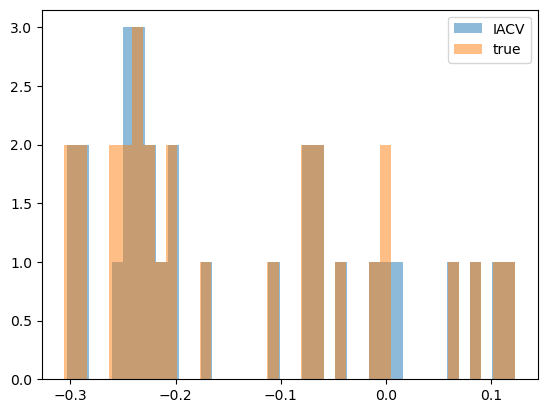

In [11]:
plt.hist(np.mean(clf.loo_iacv_, axis=0), alpha=0.5, bins=40, label="IACV")
plt.hist(np.mean(clf.loo_true_, axis=0), alpha=0.5, bins=40, label="true")
plt.legend()

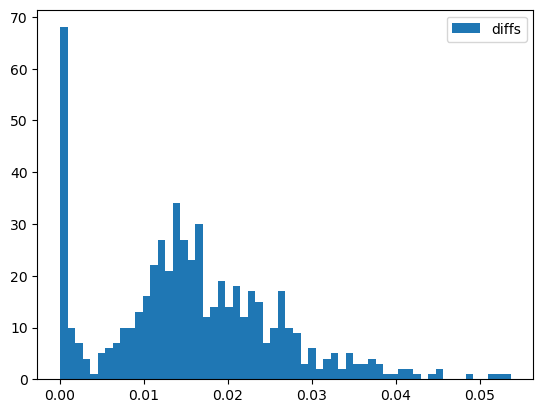

In [12]:
plt.hist(np.linalg.norm(clf.loo_iacv_ - clf.loo_true_, axis=1), bins=60, label="diffs")
plt.legend()

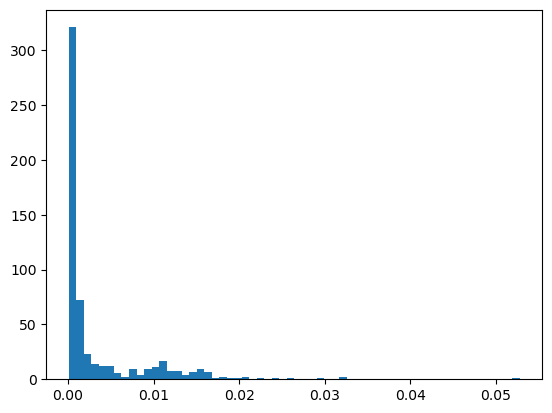

In [13]:
plt.hist(np.linalg.norm(clf.weights_ - clf.loo_true_, axis=1), bins=60, label="diffs")
plt.show()

In [14]:
clf.loo_iacv_

Array([[-0.23469223, -0.2316158 , -0.23111676, ..., -0.24046665,
        -0.21326819, -0.07121751],
       [-0.23067333, -0.2283093 , -0.22841017, ..., -0.23938762,
        -0.22158591, -0.06671334],
       [-0.23160103, -0.22202535, -0.22883676, ..., -0.2372543 ,
        -0.2165757 , -0.07369686],
       ...,
       [-0.23508976, -0.21935524, -0.23212041, ..., -0.24210617,
        -0.2254844 , -0.07185156],
       [-0.22876622, -0.2138287 , -0.22541028, ..., -0.24048209,
        -0.21707056, -0.06996657],
       [-0.22840771, -0.22895388, -0.22564696, ..., -0.24015377,
        -0.224141  , -0.07294288]], dtype=float32)

In [15]:
clf.loo_true_

array([[-0.23786725, -0.22784494, -0.23481527, ..., -0.2451868 ,
        -0.22125653, -0.07149802],
       [-0.23771424, -0.22781633, -0.23469713, ..., -0.24503585,
        -0.22132154, -0.0711897 ],
       [-0.23782157, -0.22775085, -0.23477811, ..., -0.24512213,
        -0.22125079, -0.07150473],
       ...,
       [-0.23749589, -0.22645076, -0.2344595 , ..., -0.24468118,
        -0.2220321 , -0.07152917],
       [-0.23781824, -0.2277701 , -0.23476911, ..., -0.24520182,
        -0.2212978 , -0.07149655],
       [-0.23772852, -0.22782116, -0.23468693, ..., -0.24516068,
        -0.22134032, -0.07151136]])

In [16]:
iacv_mean = np.mean(clf.loo_iacv_, axis=0)
coef = iacv_mean/np.linalg.norm(iacv_mean)
print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

diff 0.10479399561882019 | pct 0.02210739441215992


In [17]:
true_cv_mean = np.mean(clf.loo_true_, axis=0)
coef = true_cv_mean/np.linalg.norm(true_cv_mean)
print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

diff 0.10503893578032192 | pct 0.02216346671610647


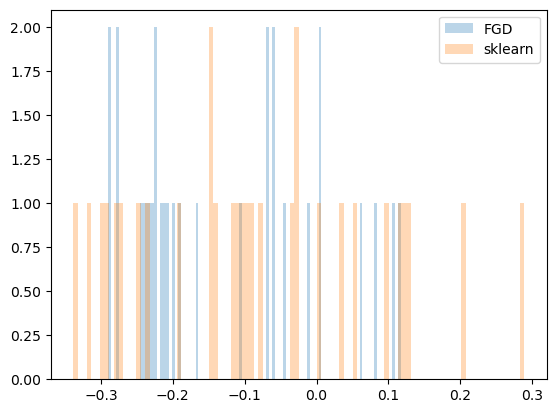

In [18]:
coef = clf.weights_/np.linalg.norm(clf.weights_)
nbin = 100
plt.hist(coef, bins=nbin, label="FGD", alpha=0.3)
plt.hist(sk_coef.flatten(), bins=nbin, label="sklearn", alpha=0.3)
plt.legend()
plt.show()

In [24]:
fig, ax = plt.subplots()
ax.plot(np.mean(clf.cond_nums_, axis=1))
ax.set_yscale('log')
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean of Hessian Condition No.")
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('svm_convergence_cond_no.pgf', bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_14662/579297558.py:9: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()


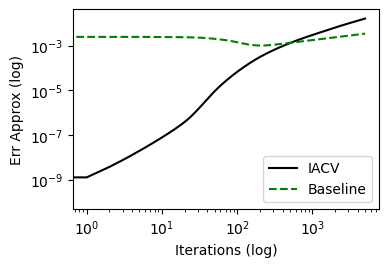

<Figure size 640x480 with 0 Axes>

In [20]:
fig, ax = plt.subplots()
ax.plot(clf.err_approx_["IACV"], label="IACV", c='black')
#ax.plot(clf.err_approx_["NS"], label="NS", c='red', linestyle="--")
ax.plot(clf.err_approx_["baseline"], label="Baseline", c='green', linestyle="--")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Iterations (log)")
ax.set_ylabel("Err Approx (log)")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('svm_convergence_err_approx.pgf', bbox_inches='tight', pad_inches=0)

In [23]:
fig, ax = plt.subplots()
ax.plot(clf.err_cv_["IACV"], label="IACV", c='black')
ax.plot(clf.err_cv_["baseline"], label="Baseline", c='green', linestyle="--")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Iterations (log)")
ax.set_ylabel("Err CV (log)")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('svm_convergence_err_cv.pgf', bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_14662/2147998014.py:12: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()


In [25]:
# test different sigma values
import time
#sigmas = [2e-30, 2e-25, 2e-15, 2e-10, 2e-5, 2e-1]
sigmas = [2e-15, 2e-10, 2e-5, 2e-3, 2e-1, 5e-1, 7e-1, 8e-1, 1, 1.25, 1.5, 2, 2.5, 5]
last_err_approx = []
last_err_cv = []

start = time.time()
for s in sigmas:
    if s == 0:
        continue
    clf = SVM_smooth(sigma=s, lbd=1e-35)
    #clf.fit(X, y, thresh=5e-3, n_iter=1000, eta=0.5 * s, cv=False, approx_cv=True, log_iacv=False, log_iter=True)
    print(f"running experiment for sigma = {s}")
    clf.fit(X_scaled, y, thresh=1e-3, n_iter=3000, eta=0.85/n, approx_cv=True, cv=True, log_iacv=False, log_iter=False,
           save_err_cv=True, save_err_approx=True)
    y_pred = clf.predict(X_scaled)
    score = accuracy_score(y, y_pred)
    print(f"\tsigma {s} | score {score} | grad {np.linalg.norm(clf.nabla_fgd_(clf.weights_, X_scaled, y, clf.sigma_, clf.lbd_))} | sklearn diff {np.mean(np.abs(coef- sk_coef))}")
    #print(clf.weights_)
    print(f"\tErr_Approx IACV: {clf.err_approx_['IACV'][-1]} | baseline: {clf.err_approx_['baseline'][-1]}" )
    print(f"\tErr_CV     IACV: {clf.err_cv_['IACV'][-1]} | baseline: {clf.err_cv_['baseline'][-1]}" )
    last_err_approx.append([clf.err_approx_["IACV"][-1], clf.err_approx_["baseline"][-1]])
    last_err_cv.append([clf.err_cv_["IACV"][-1], clf.err_approx_["baseline"][-1]])

end = time.time()
print(end - start)

running experiment for sigma = 2e-15
	sigma 2e-15 | score 0.9824253075571178 | grad 0.08394206608804457 | sklearn diff 0.10502028785494201
	Err_Approx IACV: 0.03535987809300423 | baseline: 0.003972393821030359
	Err_CV     IACV: 0.015654096379876137 | baseline: 0.01097496785223484
running experiment for sigma = 2e-10
	sigma 2e-10 | score 0.9824253075571178 | grad 0.08394206608804457 | sklearn diff 0.10502028785494201
	Err_Approx IACV: 0.03535987809300423 | baseline: 0.0039723938505640795
	Err_CV     IACV: 0.015654096379876137 | baseline: 0.01097496785223484
running experiment for sigma = 2e-05
	sigma 2e-05 | score 0.9824253075571178 | grad 0.08394202933018127 | sklearn diff 0.10502028785494201
	Err_Approx IACV: 0.021524352952837944 | baseline: 0.003971399367417702
	Err_CV     IACV: 0.0019259029068052769 | baseline: 0.010975240729749203
running experiment for sigma = 0.002
	sigma 0.002 | score 0.9824253075571178 | grad 0.08362581918851612 | sklearn diff 0.10502028785494201
	Err_Approx IA

In [26]:
last_err_cv = np.asarray(last_err_cv)
last_err_approx = np.asarray(last_err_approx)

In [27]:
fig, ax = plt.subplots()
ax.plot(sigmas, last_err_approx[:, 0], label="IACV", c='black')
ax.plot(sigmas, last_err_approx[:, 1], label="baseline", c='green', linestyle="--")
ax.set_xscale('log')
ax.set_xlabel("$\log(\sigma)$")
ax.set_ylabel("Err Approx")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('svmtest_sigma_err_approx_more_iter.pgf', bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_14662/3129144036.py:11: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()


In [30]:
fig, ax = plt.subplots()
ax.plot(sigmas, last_err_cv[:, 0], label="IACV", c='black')
ax.plot(sigmas, last_err_cv[:, 1], label="baseline", c='green', linestyle="--")
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel("$\log(\sigma)$")
ax.set_ylabel("Err CV")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('svmtest_sigma_err_cv.pgf', bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_14662/726958817.py:12: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()


In [29]:
fig, ax = plt.subplots()
ax.plot(sigmas, scores[:, 0] - scores[:, 1])
plt.show()

NameError: name 'scores' is not defined